# Import Library

In [1]:
import numpy as np
import pandas as pd 
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from custommodel import RandomForestRegressor as RF

# Data Set

In [2]:
data = pd.DataFrame(data={
    'year':[2021, 2022, 2023, 2024, 2025],
    'ndvi': [4127.14, 4741.4, 4152.37, 4187.05, 4187.05],
    'nir': [1226, 1508.19, 1234.85, 1254.16, 1254.16],
    'red': [0.54077, 0.516945, 0.540222, 0.537683, 0.537683],
    'area': [456.39, 497.77, 416, 373.61, 332.23]
})

data['year'] = pd.to_datetime(data['year'], format='%Y')

In [3]:
data

,year,ndvi,nir,red,area
0,2021-01-01,4127.14,1226.00,0.540770,456.39
1,2022-01-01,4741.40,1508.19,0.516945,497.77
2,2023-01-01,4152.37,1234.85,0.540222,416.00
3,2024-01-01,4187.05,1254.16,0.537683,373.61
4,2025-01-01,4187.05,1254.16,0.537683,332.23


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   year    5 non-null      datetime64[ns]
 1   ndvi    5 non-null      float64       
 2   nir     5 non-null      float64       
 3   red     5 non-null      float64       
 4   area    5 non-null      float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 332.0 bytes


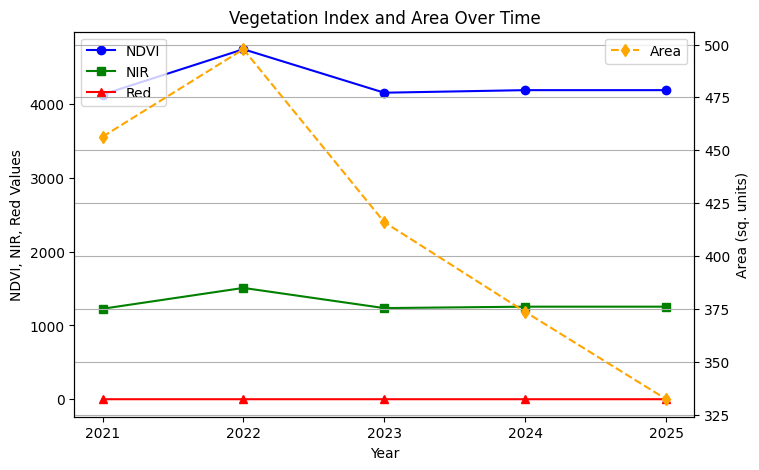

In [5]:
# Creating the plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plotting NDVI, NIR, and Red using the primary y-axis
ax1.plot(data['year'], data['ndvi'], label='NDVI', marker='o', color='b')
ax1.plot(data['year'], data['nir'], label='NIR', marker='s', color='g')
ax1.plot(data['year'], data['red'], label='Red', marker='^', color='r')
ax1.set_xlabel("Year")
ax1.set_ylabel("NDVI, NIR, Red Values")
ax1.legend(loc="upper left")

# Creating a second y-axis for Area
ax2 = ax1.twinx()
ax2.plot(data['year'], data['area'], label='Area', marker='d', linestyle='dashed', color='orange')
ax2.set_ylabel("Area (sq. units)")
ax2.legend(loc="upper right")

# Formatting x-axis as a time series with only distinct years
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())

# Ensure the years appear correctly
plt.xticks(rotation=0)

# Title and grid
plt.title("Vegetation Index and Area Over Time")
plt.grid(True)

# Show the plot
plt.show()

# Feature Selection

In [6]:
X = data.drop(columns=['area'])
y = data['area']

In [7]:
X

,year,ndvi,nir,red
0,2021-01-01,4127.14,1226.00,0.540770
1,2022-01-01,4741.40,1508.19,0.516945
2,2023-01-01,4152.37,1234.85,0.540222
3,2024-01-01,4187.05,1254.16,0.537683
4,2025-01-01,4187.05,1254.16,0.537683


In [8]:
y

0    456.39
1    497.77
2    416.00
3    373.61
4    332.23
Name: area, dtype: float64

# Hyper Parameter Tuning

In [9]:
# Define the parameter grid
param_grid = {
    "n_estimators": [10, 50, 100, 500, 1000],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
}


In [10]:
# Generate all possible combinations of parameters
param_combinations = list(product(*param_grid.values()))

# Store results
results = []

# Loop through each combination of hyperparameters
for params in param_combinations:
    # Unpack parameters
    param_dict = dict(zip(param_grid.keys(), params))
    
    # Initialize and train the model with current parameters
    model = RF(**param_dict)
    model.fit(X, y)
    
    # Make predictions on validation set
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    
    # Save results in a list
    results.append({**param_dict, 'MSE': mse})

    # Print results
    print(f"Params: {param_dict}, MSE: {mse:.4f}")

# Convert results to DataFrame
df_results = pd.DataFrame(results)

Params: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2}, MSE: 285.4860
Params: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 5}, MSE: 614.8814
Params: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 10}, MSE: 3624.3296
Params: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 2}, MSE: 666.5748
Params: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 5}, MSE: 725.5080
Params: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 10}, MSE: 3523.2223
Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2}, MSE: 581.4593
Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 5}, MSE: 505.9284
Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 10}, MSE: 3539.8329
Params: {'n_estimators': 10, 'max_depth': 20, 'min_samples_split': 2}, MSE: 453.0952
Params: {'n_estimators': 10, 'max_depth': 20, 'min_samples_split': 5}, MSE: 636.3874
Params: {'n_estimators': 10, 'max_depth': 20, 'min_sampl

In [11]:
best_params = df_results.loc[df_results['MSE'].idxmin()]
print(best_params)

n_estimators          10.000000
max_depth                   NaN
min_samples_split      2.000000
MSE                  285.485968
Name: 0, dtype: float64


# Train Random Forest

In [12]:
rf = RF(n_estimators=50, min_samples_split=2, max_depth=None, verbose=True)
rf.fit(X, y)

Tree 1/50 telah dilatih.
Tree 2/50 telah dilatih.
Tree 3/50 telah dilatih.
Tree 4/50 telah dilatih.
Tree 5/50 telah dilatih.
Tree 6/50 telah dilatih.
Tree 7/50 telah dilatih.
Tree 8/50 telah dilatih.
Tree 9/50 telah dilatih.
Tree 10/50 telah dilatih.
Tree 11/50 telah dilatih.
Tree 12/50 telah dilatih.
Tree 13/50 telah dilatih.
Tree 14/50 telah dilatih.
Tree 15/50 telah dilatih.
Tree 16/50 telah dilatih.
Tree 17/50 telah dilatih.
Tree 18/50 telah dilatih.
Tree 19/50 telah dilatih.
Tree 20/50 telah dilatih.
Tree 21/50 telah dilatih.
Tree 22/50 telah dilatih.
Tree 23/50 telah dilatih.
Tree 24/50 telah dilatih.
Tree 25/50 telah dilatih.
Tree 26/50 telah dilatih.
Tree 27/50 telah dilatih.
Tree 28/50 telah dilatih.
Tree 29/50 telah dilatih.
Tree 30/50 telah dilatih.
Tree 31/50 telah dilatih.
Tree 32/50 telah dilatih.
Tree 33/50 telah dilatih.
Tree 34/50 telah dilatih.
Tree 35/50 telah dilatih.
Tree 36/50 telah dilatih.
Tree 37/50 telah dilatih.
Tree 38/50 telah dilatih.
Tree 39/50 telah dila

# Evaluate the Model

In [13]:
mean_squared_error(y, rf.predict(X))

351.9982620239952

In [14]:
mean_absolute_error(y, rf.predict(X))

16.267159999999897

In [15]:
r2_score(y, rf.predict(X))

0.8972496448895179

# Save the Model

In [16]:
rf.save_model("./rfmodel.pkl")